In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import ot
import os

In [2]:
from OTFramework import LOT

In [3]:
class SDE_General2D(object):
    # parameters :
        # x : (num_cells,) points
        # h : float step size
        # mu : ((num_cells,), float) -> (num_cells,)
        # sigma : ((num_cells,), float) -> (num_cells,)
        # time : float
        # x_bounds : (2,) bounds for cell location

    def __init__(self, x, h, mu, sigma, time, x_bounds=None):
        self.x = x
        self.h = h
        self.mu = mu
        self.sigma = sigma
        self.time = time
        self.x_bounds = x_bounds

        self.num_cells = self.x.shape[0]
        self.num_dim = self.x.shape[1]
    
    def take_step(self,):
        x_step_mu = self.mu(self.x, self.time)
        x_step_sigma = self.sigma(self.x, self.time)
        x_step_delta_w = np.random.multivariate_normal(np.zeros(2), self.h*np.identity(2), size=self.num_cells)
        x_step = x_step_mu*self.h + x_step_sigma*x_step_delta_w
        self.x = self.x + x_step
        
        self.time = self.time + self.h


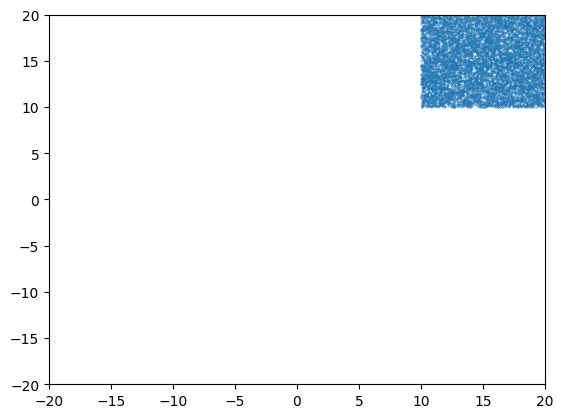

1
0.0727535441177919
2
0.9980247680297056
3


KeyboardInterrupt: 

In [5]:
# SDE2D

NUM_PARTS = 10000
H = 1/128

NUM_NEWTON_STEPS = 5
NUM_STEPS_FOR_ORACLE_STEP = 16
NUM_BURNIN_STEPS = 32

NUM_KRYLOV_DIMS = 10

def mu(x,t):
    return -x
def sigma(x,t):
    return 1

x_newton = np.zeros((NUM_NEWTON_STEPS+1, NUM_PARTS, 2))
DOTSIZE = 0.1
XLIM = [-20,20]
YLIM = [-20,20]

krylov_q = np.zeros((NUM_KRYLOV_DIMS+1,NUM_PARTS*2))
krylov_w = np.zeros((NUM_KRYLOV_DIMS,NUM_PARTS*2))
krylov_h = np.zeros((NUM_KRYLOV_DIMS+1,NUM_KRYLOV_DIMS))

x_start_init = np.random.uniform(10,20,size=(NUM_PARTS,2))
x_start = x_start_init
sde1 = SDE_General2D(x_start, H, mu, sigma, 0)

lot1 = LOT(x_start, x_start, max_num_iter=1000000)

x_newton[0] = x_start
plt.figure()
plt.scatter(*x_newton[0].T, s=DOTSIZE)
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.show()

for k in range(NUM_NEWTON_STEPS):
    for n in range(NUM_STEPS_FOR_ORACLE_STEP):
        sde1.take_step()
    lot1.x_tar = sde1.x
    x_after_one_oracle_step = lot1.calc_ot_map()
    
    b = -(x_after_one_oracle_step - x_start).flatten()
    beta = np.linalg.norm(b)
    krylov_q[0] = b/beta

    for j in range(NUM_KRYLOV_DIMS):
        print(j+1)
        DELTA = 1/np.average(np.abs(krylov_q[j]))
        # print(DELTA)
        x_start_perturbed = x_start + DELTA*krylov_q[j].reshape(NUM_PARTS,2)
        sde1.x = x_start_perturbed
        for n in range(NUM_STEPS_FOR_ORACLE_STEP):
            sde1.take_step()
        lot1.x_tar = sde1.x
        x_after_one_oracle_step_perturbed = lot1.calc_ot_map()
        krylov_w[j] = (x_after_one_oracle_step_perturbed - x_after_one_oracle_step).flatten()/DELTA-krylov_q[j]
        for i in range(j+1):
            krylov_h[i,j] = np.dot(krylov_w[j],krylov_q[j])
            krylov_w[j] -= krylov_h[i,j]*krylov_q[i]
        krylov_h[j+1,j] = np.linalg.norm(krylov_w[j])
        # print(krylov_h[j+1,j])
        if np.abs(krylov_h[j+1,j])<1e-10:
            m = j+1
            print("BREAKING BECAUSE np.abs(krylov_h[j+1,j]) = " + str(np.abs(krylov_h[j+1,j])))
            krylov_q = krylov_q[0:m]
            krylov_w = krylov_w[0:m]
            krylov_h = krylov_h[0:m+1,0:m]
            break
        krylov_q[j+1] = krylov_w[j]/krylov_h[j+1,j]
    m = j+1
    # print("m is " + str(m))
    # print("Shape of H is " + str(np.shape(krylov_h)))
    # print("Shape of V is " + str(np.shape(krylov_q)))
    y_m = np.linalg.lstsq(krylov_h,beta*np.eye(1,m+1,0).reshape(m+1,), rcond=None)[0]
    
    x_update = (krylov_q[0:m].T@y_m).reshape(NUM_PARTS,2)
    x_next = x_start + x_update

    plt.figure()
    plt.scatter(*x_next.T, s=DOTSIZE)
    plt.xlim(XLIM)
    plt.ylim(YLIM)
    plt.show()
    
    sde1.x = x_next
    print("BURNING IN...")
    for n in range(NUM_BURNIN_STEPS):
        sde1.take_step()
    
    x_start = sde1.x
    x_newton[k+1] = x_start
    lot1.x_ref = x_start

    plt.figure()
    plt.scatter(*x_newton[k+1].T, s=DOTSIZE)
    plt.xlim(XLIM)
    plt.ylim(YLIM)
    plt.show()

